In [ ]:
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torcheval.metrics as metrics
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import os
# data_path = '/kaggle/input'
data_path = "./data"
for dirname, _, filenames in os.walk(data_path):
    print(dirname)
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Set env CUDA_LAUNCH_BLOCKING=1
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

./data
./data\mnist_test.csv
./data\mnist_train.csv


## Task 3
Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images. But, the test set remains the same 10,000 images. Compare against RF and Logistic Regression models. The metrics can be: F1-score, confusion matrix. What do you observe? What all digits are commonly confused?

Let us assume your MLP has 30 neurons in first layer, 20 in second layer and then 10 finally for the output layer (corresponding to 10 classes). On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model. What do you conclude?

Now, use the trained MLP to predict on the Fashion-MNIST dataset. What do you observe? How do the embeddings (t-SNE viz for the second layer compare for MNIST and Fashion-MNIST images

> Loading the train set into a custom `PyTorch Dataset` and `DataLoader`  
> The first column of the DataFrame contains the image label and the remaining columns contains the pixel value.

In [ ]:
mnist_train = pd.read_csv("./data/mnist_train.csv")
mnist_test = pd.read_csv("./data/mnist_test.csv")

In [ ]:
train_X = mnist_train.iloc[:, 1:].to_numpy().astype(np.float32)   # numpy array with train X data
train_Y = mnist_train.iloc[:, 0].to_numpy()                       # numpy array with train Y data
test_X = mnist_test.iloc[:, 1:].to_numpy().astype(np.float32)     # numpy array with test X data
test_Y = mnist_test.iloc[:, 0].to_numpy()                         # numpy array with test Y data

class MnistDataset(Dataset):
    def __init__(self, X, Y):
        self.x , self.y = torch.from_numpy(X), torch.from_numpy(Y)
    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]
    def __len__(self):
        return len(self.x)

train_dataset = MnistDataset(train_X, train_Y)
test_dataset = MnistDataset(test_X, test_Y)

Loading the `train_dataset` into a `DataLoader`,  Each iteration over the `DataLoader` object returns a batch of train_features and train_labels

In [ ]:
batch = 256

train_loader = DataLoader(train_dataset, batch_size= batch, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size= batch, shuffle= False)

> Inspecting one image

Image Label: 5


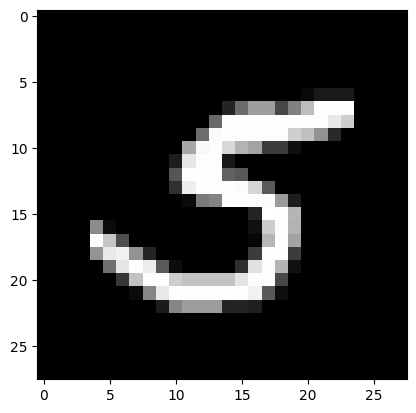

In [ ]:
def show_digit(X: torch.Tensor):
    '''Show the tensor X as an image'''
    plt.imshow(X.reshape(28, 28), cmap='grey')

index = 239
img = torch.Tensor(mnist_train.iloc[index][1:])
show_digit(img)
print("Image Label:", mnist_train.iloc[index][0])

### Defining the MLP Architecture
- The input layer must have 28 x 28 = 784 neurons
- The 1st Hidden layer can have any number of neurons. Here we take 512 neurons
- In the 2nd hidden layer, we take 256 neurons
- The outpur layer has 10 neurons for 10 classes (0-9)

In [ ]:
first_layer, second_layer = 512, 256

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, first_layer)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(first_layer, second_layer)  # Second layer
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(second_layer, 10)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        second_activations = self.relu2(self.layer2(x)) # second layer output
        logits = self.output_layer(second_activations)
        return second_activations, logits
    
mnist_model = MLP()
mnist_model.to(device)

MLP(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)

> Seeing the Untrained Model

('Prediction:', 8)

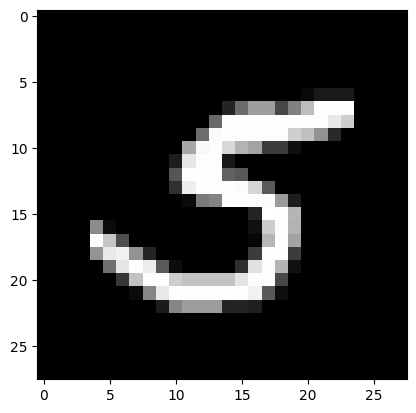

In [ ]:
_, output = mnist_model(img.to(device))
show_digit(img)
"Prediction:", np.argmax(output.detach().cpu().numpy())

- _t-SNE for the __untrained__ model_ with __256 neurons in 2nd layer__

In [ ]:
from sklearn.manifold import TSNE

def tSNE(model, title):
    all_activations = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            activations, _ = model(data)
            all_activations.append(activations.cpu())
            all_labels.extend(labels.numpy())

    all_activations = torch.cat(all_activations).cpu().numpy()  # concatenating between all the batches (40)
    all_labels = np.array(all_labels)

    tsne = TSNE(n_components=3) # 3d tSNE
    tsne_results = tsne.fit_transform(all_activations)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], c=all_labels, cmap='tab10', alpha=0.7)
    legend = ax.legend(*scatter.legend_elements(), title="Digits")
    ax.add_artist(legend)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    ax.set_title(f'3D t-SNE of Second Layer Activations - {title} model')
    plt.show()

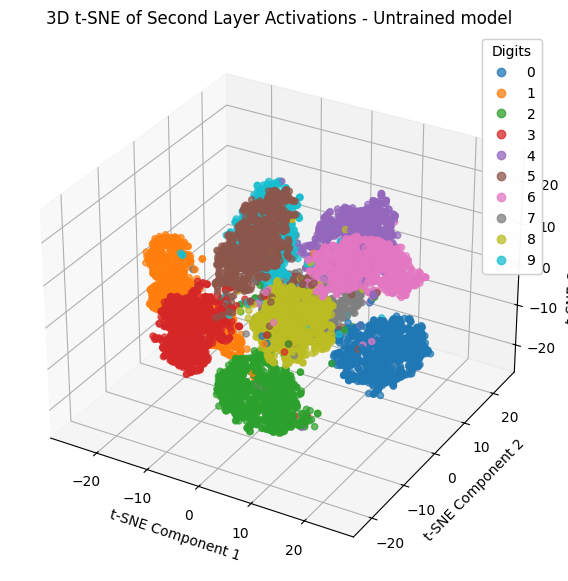

In [ ]:
tSNE(mnist_model, "Untrained")

- _Accuracy for untrained model on test dataset_

In [ ]:
outputs = torch.tensor([], device=device)

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        _, output = mnist_model(data)
        outputs = torch.cat((outputs, output))

acc = metrics.MulticlassAccuracy()
accuracy = acc.update(outputs, test_dataset.y).compute()
print("Accuracy:", accuracy.item() * 100)

Accuracy: 9.89999994635582


> ### Training the MLP

In [ ]:
learning_rate = 0.0005
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_model.parameters(), lr=learning_rate)

def train(model, loader, epochs=5):
    '''takes a model and dataloader and trains the model using it'''
    acc = metrics.MulticlassAccuracy()
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(loader):
            # Move data and target to the correct device
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            _, output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}, training accuracy: {acc.update(output, target).compute()}')
    
    print('Finished Training')

train(mnist_model, train_loader, epochs)

Epoch [1/20], Step [0/235], Loss: 10.2137, training accuracy: 0.0859375
Epoch [1/20], Step [100/235], Loss: 0.3473, training accuracy: 0.494140625
Epoch [1/20], Step [200/235], Loss: 0.1383, training accuracy: 0.6471354365348816
Epoch [2/20], Step [0/235], Loss: 0.0955, training accuracy: 0.7275390625
Epoch [2/20], Step [100/235], Loss: 0.0297, training accuracy: 0.780468761920929
Epoch [2/20], Step [200/235], Loss: 0.0724, training accuracy: 0.8131510615348816
Epoch [3/20], Step [0/235], Loss: 0.0491, training accuracy: 0.8376116156578064
Epoch [3/20], Step [100/235], Loss: 0.0263, training accuracy: 0.85693359375
Epoch [3/20], Step [200/235], Loss: 0.1346, training accuracy: 0.8676215410232544
Epoch [4/20], Step [0/235], Loss: 0.0372, training accuracy: 0.8792968988418579
Epoch [4/20], Step [100/235], Loss: 0.0260, training accuracy: 0.8899147510528564
Epoch [4/20], Step [200/235], Loss: 0.0829, training accuracy: 0.8977864384651184
Epoch [5/20], Step [0/235], Loss: 0.0182, training 

- _t-SNE for the __trained__ model_

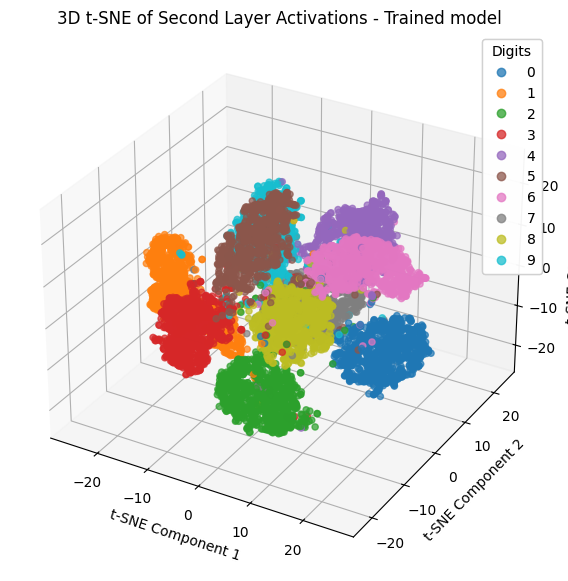

In [ ]:
tSNE(mnist_model, "Trained")

### Defining a smaller MLP (30 and 20 hidden neurons respectively) for seeing tSNE of embeddings

In [ ]:
first_layer, second_layer = 30, 20

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, first_layer)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(first_layer, second_layer)  # Second layer
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(second_layer, 10)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        second_activations = self.relu2(self.layer2(x)) # second layer output
        logits = self.output_layer(second_activations)
        return second_activations, logits
    
mnist_model_small = MLP()
mnist_model_small.to(device)

MLP(
  (layer1): Linear(in_features=784, out_features=30, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=30, out_features=20, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=20, out_features=10, bias=True)
)

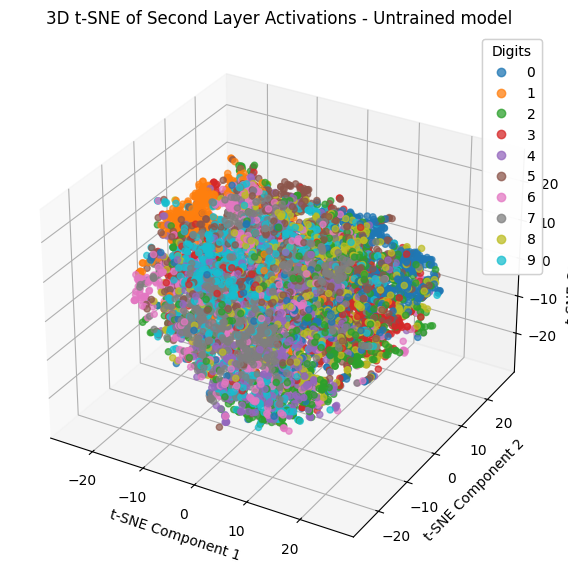

In [ ]:
tSNE(mnist_model_small, "Untrained")

> ### Evaluating the trained `mnist_model` on the `test_dataset`  
> Using `torcheval.metrics` module and `sklearn.metrics` module to calculate the metrics

In [ ]:
num_0 = len(mnist_test.loc[mnist_test['label'] == 0])
num_1 = len(mnist_test.loc[mnist_test['label'] == 1])
num_2 = len(mnist_test.loc[mnist_test['label'] == 2])
num_3 = len(mnist_test.loc[mnist_test['label'] == 3])
num_4 = len(mnist_test.loc[mnist_test['label'] == 4])
num_5 = len(mnist_test.loc[mnist_test['label'] == 5])
num_6 = len(mnist_test.loc[mnist_test['label'] == 6])
num_7 = len(mnist_test.loc[mnist_test['label'] == 7])
num_8 = len(mnist_test.loc[mnist_test['label'] == 8])
num_9 = len(mnist_test.loc[mnist_test['label'] == 8])
print(f'Number of 0s in test set: {num_0}')
print(f'Number of 1s in test set: {num_1}')
print(f'Number of 2s in test set: {num_2}')
print(f'Number of 3s in test set: {num_3}')
print(f'Number of 4s in test set: {num_4}')
print(f'Number of 5s in test set: {num_5}')
print(f'Number of 6s in test set: {num_6}')
print(f'Number of 7s in test set: {num_7}')
print(f'Number of 8s in test set: {num_8}')
print(f'Number of 9s in test set: {num_9}')

Number of 0s in test set: 980
Number of 1s in test set: 1135
Number of 2s in test set: 1032
Number of 3s in test set: 1010
Number of 4s in test set: 982
Number of 5s in test set: 892
Number of 6s in test set: 958
Number of 7s in test set: 1028
Number of 8s in test set: 974
Number of 9s in test set: 974


5

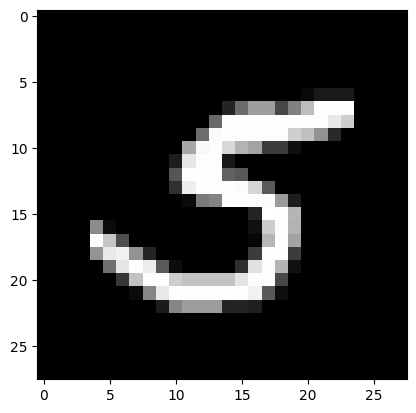

In [ ]:
# seeing output (argmax on logits) using the same input img used before
_, output = mnist_model(img.to(device))
show_digit(img)
output.argmax().item()

In [ ]:
outputs = torch.tensor([], device=device)

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        _, output = mnist_model(data)
        outputs = torch.cat((outputs, output))

acc = metrics.MulticlassAccuracy()
accuracy = acc.update(outputs, test_dataset.y).compute()
print("Accuracy:", accuracy.item() * 100)

Accuracy: 97.71000146865845


Confusion Matrix


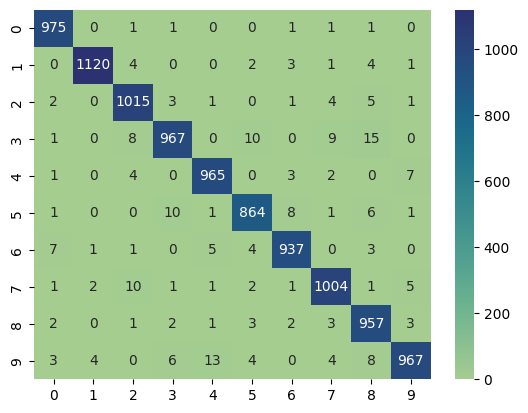

In [ ]:
# creating confusion matrix for the model
from sklearn.metrics import confusion_matrix

preds = outputs.argmax(dim=-1)
cfm = confusion_matrix(test_dataset.y.cpu(), preds.cpu())

# plotting the confusion matrix with seaborn
import seaborn as sns
sns.heatmap(cfm, annot=True, fmt="d", cmap="crest")
print("Confusion Matrix")


In [ ]:
f1 = metrics.MulticlassF1Score(num_classes=10, average='macro')
f1_score = f1.update(outputs, test_dataset.y).compute()
print("macro f1 score:", f1_score.item() * 100)
f1 = metrics.MulticlassF1Score(num_classes=10, average='micro')
f1_score = f1.update(outputs, test_dataset.y).compute()
print("micro f1 score:", f1_score.item() * 100)

macro f1 score: 97.68688082695007
micro f1 score: 97.71000146865845


_We can see that the micro f1-score is the same as accuracy in this case._  
_"In __classification tasks for which every test case is guaranteed to be assigned to exactly one class, micro-F is equivalent to accuracy.__ It won't be the case in multi-label classification." - [Source](https://stackoverflow.com/questions/37358496/is-f1-micro-the-same-as-accuracy)_

> ### Comparign with `Random Forests` model and `Logistic Regression` Model

In [ ]:
# Initialize and train the Random Forest classifier for different number of estimators (DTs)
n_trees = 201
accuracies = []
for i in range(1, n_trees + 1, 50):
    rf_model = RandomForestClassifier(n_estimators=i, random_state=42)
    rf_model.fit(train_X, train_Y)

    # predictions on the test set
    y_pred = rf_model.predict(test_X)

    accuracy = acc.update(torch.tensor(y_pred), torch.tensor(test_Y)).compute()
    accuracies.append(accuracy)

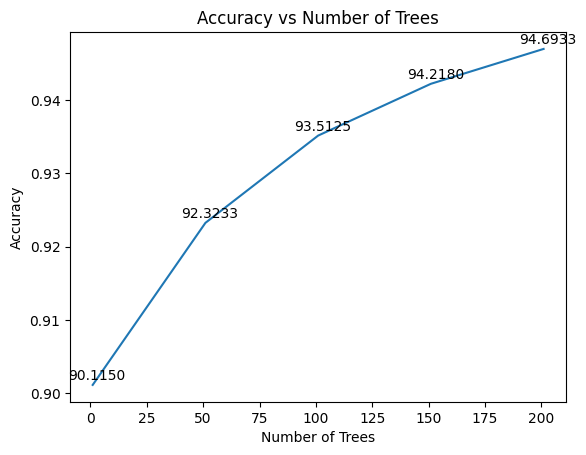

In [ ]:
X = list(range(1, n_trees + 1, 50))
plt.plot(X, accuracies)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Trees')

# Add labels for each y value
for i, txt in enumerate(accuracies):
    plt.text(X[i]+ 2, accuracies[i] + 0.0003, f"{(txt.item() * 100):.4f}", ha='center', va='bottom', fontsize=10, color='black')

Confusion Matrix for RF with 201 DTs


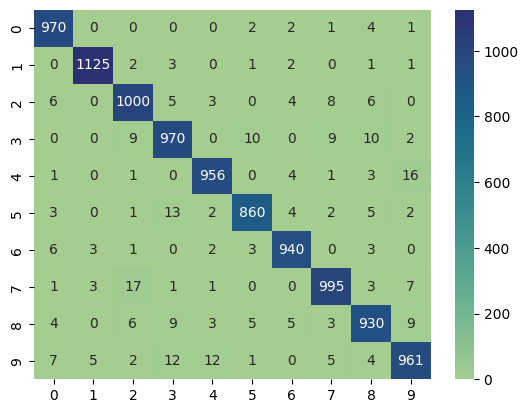

In [ ]:
# confusion matrix
cfm = confusion_matrix(test_Y, y_pred)
sns.heatmap(cfm, annot=True, fmt="d", cmap="crest")
print("Confusion Matrix for RF with 201 DTs")

In [ ]:
f1 = metrics.MulticlassF1Score(num_classes=10, average='macro')
f1_score = f1.update(torch.tensor(y_pred), torch.tensor(test_Y)).compute()
print("macro f1 score:", f1_score.item() * 100)

macro f1 score: 97.04720377922058


> Now, `Logistic Regression`

In [ ]:
# Initialize and train the Logistic Regression classifier on standardized train_X
from sklearn.preprocessing import MinMaxScaler

max_iters_limit = 400
logistic_accuracies = []
# standardizing input X
scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.fit_transform(test_X)

X = range(50, max_iters_limit + 1, 50)
for i in X:
    lr_model = LogisticRegression(max_iter=i, multi_class='multinomial')
    lr_model.fit(train_X_scaled, train_Y)

    # predictions on the test set
    y_pred = lr_model.predict(test_X_scaled)

    accuracy = acc.update(torch.tensor(y_pred), torch.tensor(test_Y)).compute()
    logistic_accuracies.append(accuracy)

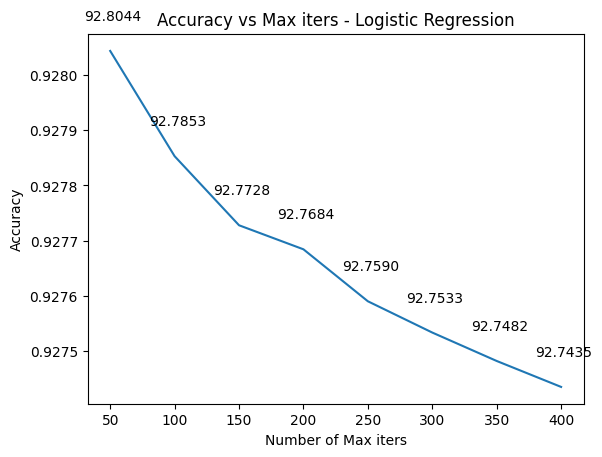

In [ ]:
plt.plot(list(X), logistic_accuracies)
plt.xlabel('Number of Max iters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max iters - Logistic Regression')

# Add labels for each y value
for i, txt in enumerate(logistic_accuracies):
    plt.text(X[i]+ 2, logistic_accuracies[i] + 0.00005, f"{(txt.item() * 100):.4f}", ha='center', va='bottom', fontsize=10, color='black')

Confusion Matrix for Logistic Regression with 400 max_iters


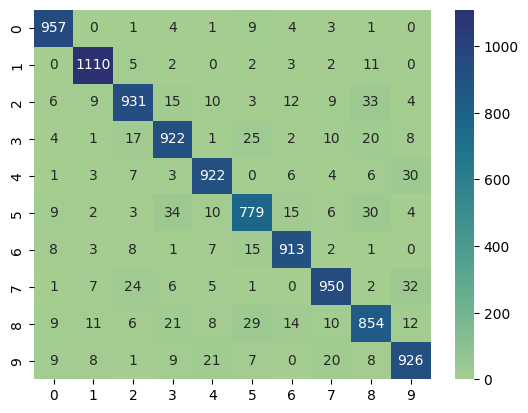

In [ ]:
# confusion matrix
cfm = confusion_matrix(test_Y, y_pred)
sns.heatmap(cfm, annot=True, fmt="d", cmap="crest")
print("Confusion Matrix for Logistic Regression with 400 max_iters")

In [ ]:
f1 = metrics.MulticlassF1Score(num_classes=10, average='macro')
f1_score = f1.update(torch.tensor(y_pred), torch.tensor(test_Y)).compute()
print("macro f1 score:", f1_score.item())

macro f1 score: 0.9253088235855103


> ### Comparison Table
| Model  | Accuracy | F1 Score (macro) | Comments on Confusion Matrix |
|-|-|-|-|
| MLP | 97.71% | 0.9768 | Excellent performance; low confusion among classes. |
| Random Forest (200 DTs) | 94.69% | 0.9705| Good balance; some misclassifications in semantically similar digits. |
| Logistic Regression | 92.74% | 0.9253 | more misclassifications in semantically similar digits. |

#### __Commonly Confused Digits:__
- 1 and 2 are confused, possible because of writing two in a narrow way or 1 in different style other than a straight line.
- 7 ans 1 are confused, possible because of the horizontal line of 7 being short.
- 3 ans 8 are confused, possible as both the numbers have similar semantics.
- 4 and 9 are confused, possible as both the numbers have similar semantics.
- 7 ans 2 are confused, possible because of similar semantics.
- 7 and 9 are confused, possible because of similar semantics.